<a href="https://colab.research.google.com/github/sriharisivashanmugam/BlowerFault/blob/main/Blower_Fault_v2_Jan_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For every heater, regardless of period of data available, do feature engineering, normalize them temporally by period of data available and have 2 clusters faulty/non-fauly, analyze the two clusters for significant differences and try predicting new heaters in the clusters.

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [47]:
def had_fault(data):
  if 'E1.0' in set(data['ErrorCode']):
    return True
  else:
    return False

def number_of_unique_faults(data):
  data['lag_error'] = data['ErrorCode'].shift(1)
  return data[(data['ErrorCode']=='E1.0') & (data['lag_error']!='E1.0')].shape[0]

def get_stats(data):
  if had_fault(data)==True:
    data['lag'] = data['ErrorCode'].shift(1)
    end = int(data[(data['ErrorCode']=='E1.0') & (data['lag']!='E1.0')].index[0])
    data = data.iloc[0:end+1,:]
  mean_pwm = data['BlowerPWM'].mean()
  mean_rpm = data['BlowerRPM'].mean()
  mean_fr = data['FiringRate'].mean()
  mean_ft = data['FlueTemperature'].mean()
  max_pwm = data['BlowerPWM'].max()
  max_rpm = data['BlowerRPM'].max()
  max_fr = data['FiringRate'].max()
  max_ft = data['FlueTemperature'].max()

  return mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft

def get_agg(data):
  pass


In [48]:
new_df = {'HEX':[],'mean_pwm':[],'mean_rpm':[],'mean_fr':[],'mean_ft':[],'max_pwm':[],'max_rpm':[],'max_fr':[],'max_ft':[],'had_fault':[]}
for i in os.listdir('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault-training/Hex_with_blowerFault/'):
  temp = pd.read_csv('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault-training/Hex_with_blowerFault/'+i)
  temp = temp[['BlowerPWM','BlowerRPM','FiringRate','FlueTemperature','ErrorCode']]

  new_df['HEX'].append(i.split('.')[0])
  res = get_stats(temp)
  # print(i,had_fault(temp),number_of_unique_faults(temp),res)
  # print(i)
  new_df['mean_pwm'].append(res[0])
  new_df['mean_rpm'].append(res[1])
  new_df['mean_fr'].append(res[2])
  new_df['mean_ft'].append(res[3])
  new_df['max_pwm'].append(res[4])
  new_df['max_rpm'].append(res[5])
  new_df['max_fr'].append(res[6])
  new_df['max_ft'].append(res[7])
  new_df['had_fault'].append(had_fault(temp))

new_df = pd.DataFrame(new_df)

In [49]:
new_df = new_df[new_df['max_rpm']>0]

In [50]:
new_df.describe()

,mean_pwm,mean_rpm,mean_fr,mean_ft,max_pwm,max_rpm,max_fr,max_ft
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,230.640365,6206.135789,15.050409,102.146530,356.153846,8476.769231,197.333333,126.794872
std,59.133195,1071.456876,11.485131,8.430361,30.357986,368.423916,65.698808,9.597641
min,113.595178,4118.827813,0.000000,83.000000,293.000000,7597.000000,0.000000,83.000000
25%,189.194474,5483.285174,5.940104,95.527897,345.500000,8333.500000,155.000000,123.000000
50%,237.119023,6162.978292,15.471253,103.184695,353.000000,8366.000000,234.000000,127.000000
75%,272.967454,7144.616034,20.676717,109.379103,364.500000,8624.000000,251.000000,133.000000
max,316.604897,7788.624666,51.747328,114.187443,450.000000,9425.000000,251.000000,142.000000


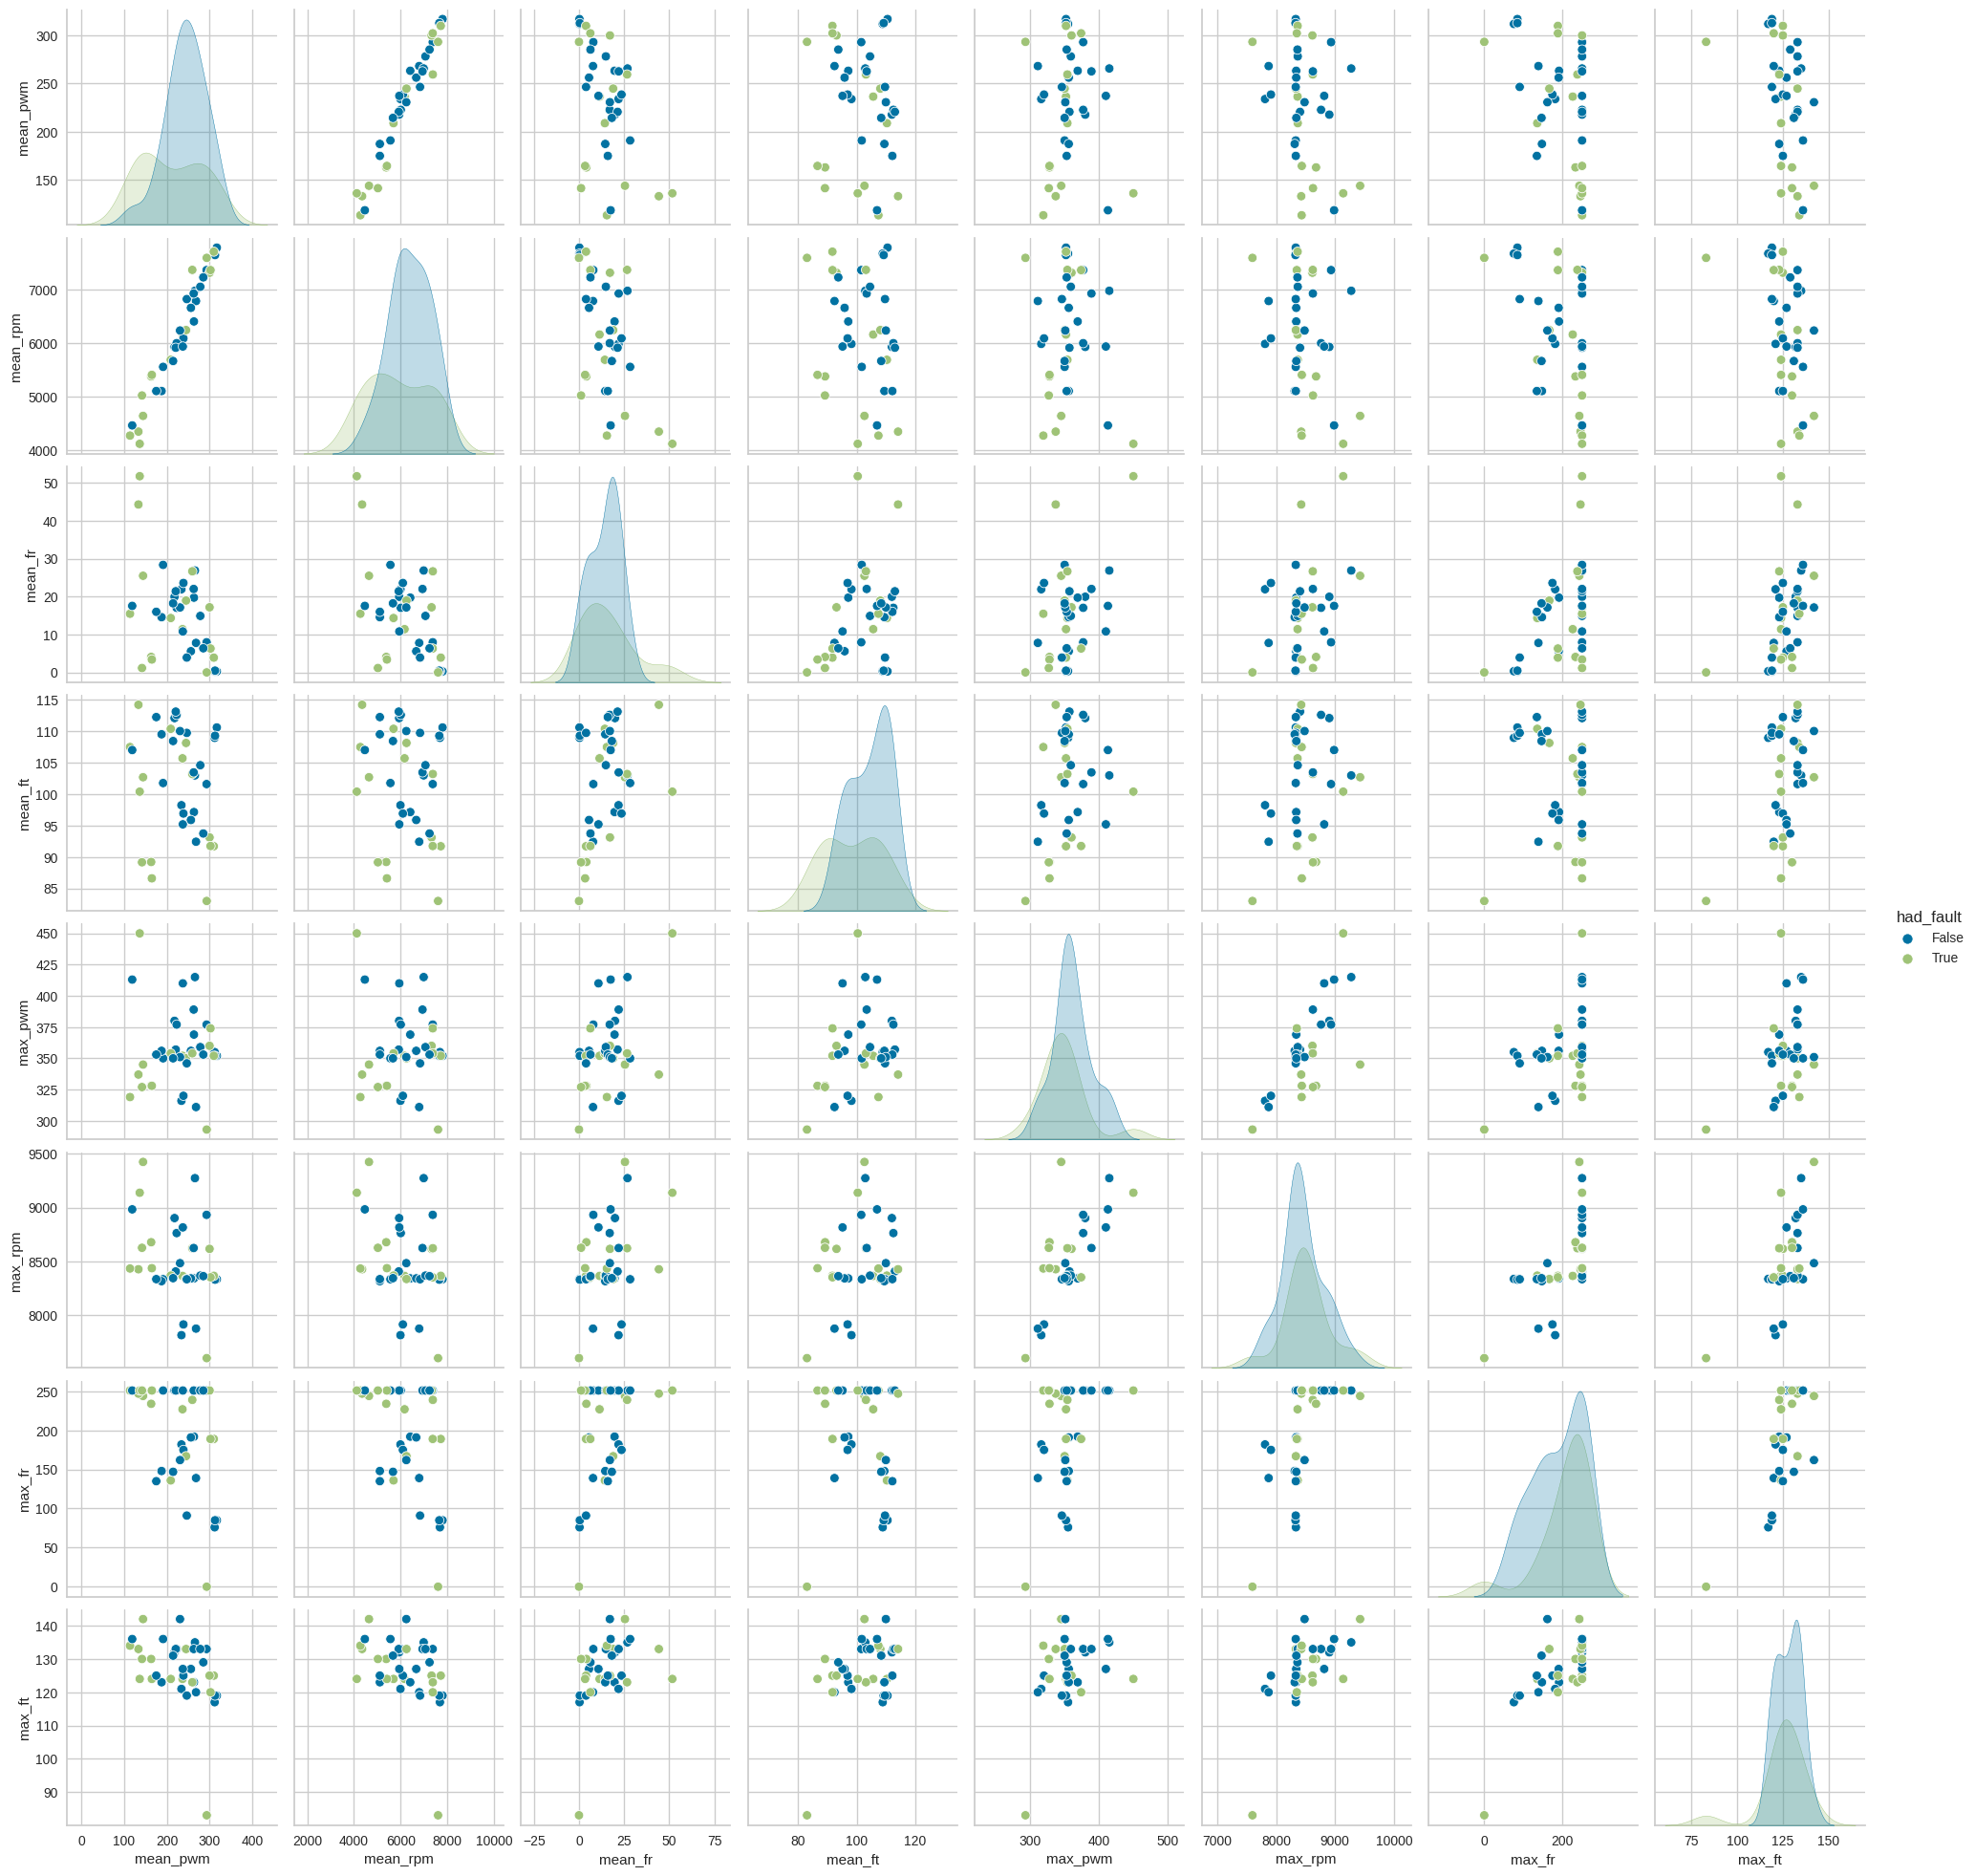

In [51]:
sns.pairplot(new_df,hue='had_fault')

In [52]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X = new_df.iloc[:,1:-1]
Y = new_df.iloc[:,-1]
X = pd.DataFrame(ss.fit_transform(X))
final_df = pd.concat([X,Y],axis=1)

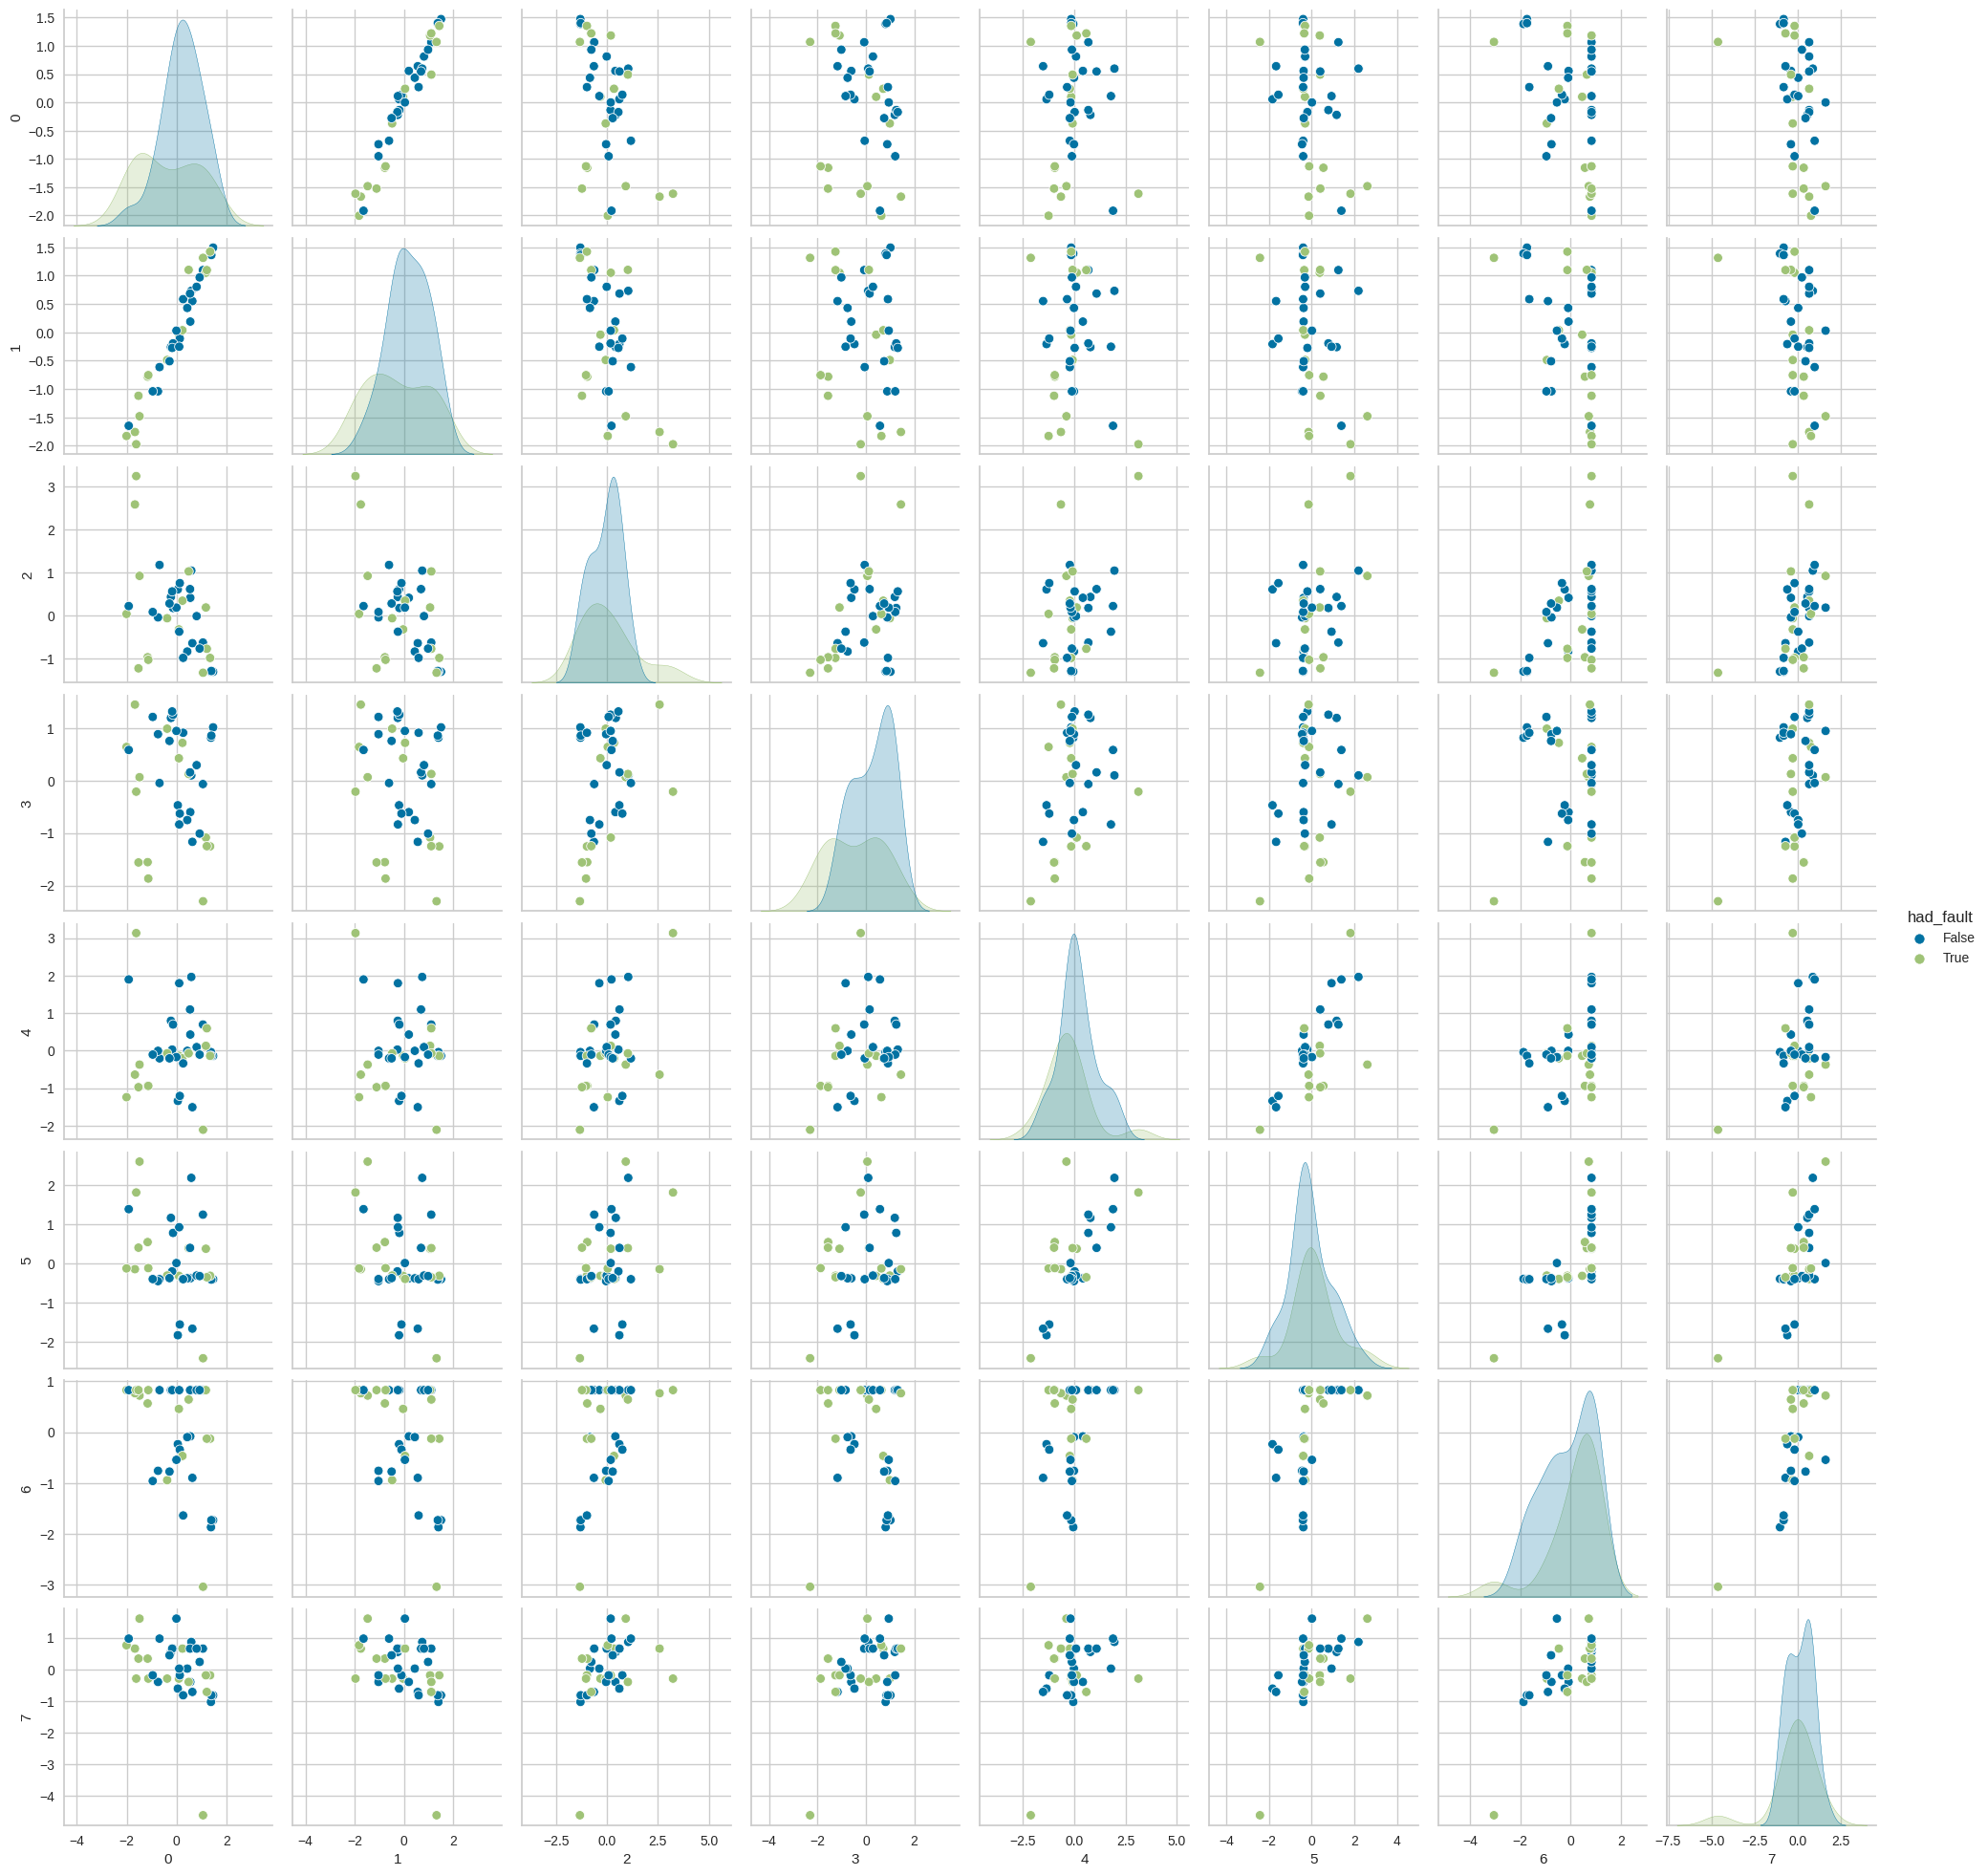

In [54]:
sns.pairplot(final_df,hue='had_fault')

In [55]:
# pip install pycaret

In [56]:
from pycaret.classification import *
s = setup(final_df, target = 'had_fault', session_id = 124)

,Description,Value
0,Session id,124
1,Target,had_fault
2,Target type,Binary
3,Original data shape,"(39, 9)"
4,Transformed data shape,"(39, 9)"
5,Transformed train set shape,"(27, 9)"
6,Transformed test set shape,"(12, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [70]:
best = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7167,0.5000,0.4000,0.3500,0.3667,0.3000,0.3000,0.1910
lda,Linear Discriminant Analysis,0.7167,0.6500,0.5000,0.4000,0.4333,0.3300,0.3500,0.0260
lr,Logistic Regression,0.7000,0.6500,0.3000,0.2500,0.2667,0.2400,0.2500,0.7440
ridge,Ridge Classifier,0.7000,0.0000,0.4000,0.3500,0.3667,0.2900,0.3000,0.0420
qda,Quadratic Discriminant Analysis,0.6333,0.3750,0.2000,0.2000,0.2000,0.1200,0.1000,0.0260
xgboost,Extreme Gradient Boosting,0.6333,0.5000,0.4000,0.4000,0.4000,0.1500,0.1500,0.0870
nb,Naive Bayes,0.6167,0.4000,0.3000,0.3000,0.3000,0.1000,0.1000,0.0480
ada,Ada Boost Classifier,0.6167,0.6000,0.5000,0.3000,0.3667,0.1300,0.1500,0.1040
lightgbm,Light Gradient Boosting Machine,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1240
dummy,Dummy Classifier,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0250


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

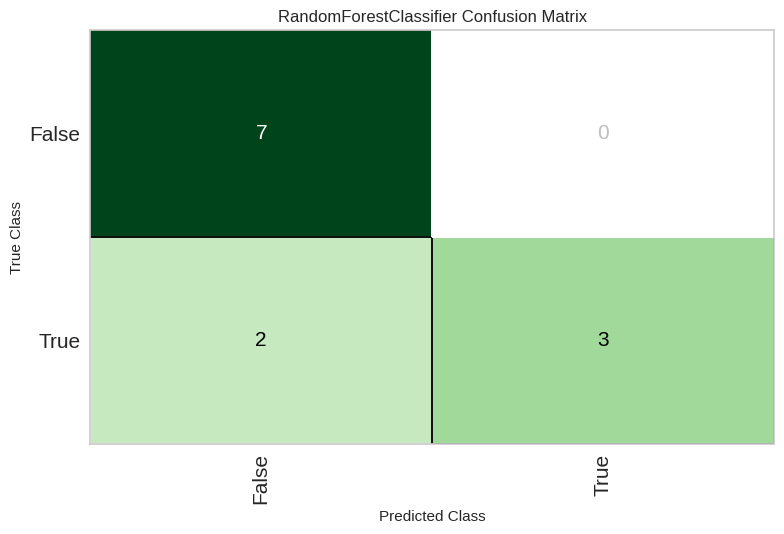

In [71]:
plot_model(best, plot = 'confusion_matrix')

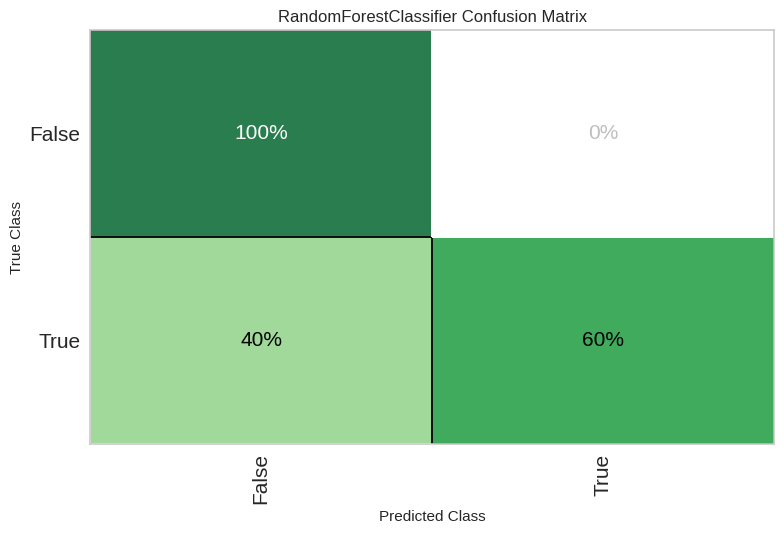

In [72]:
plot_model(best, plot = 'confusion_matrix',plot_kwargs={'percent':True})

In [73]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8333,0.8571,0.6000,1.0000,0.7500,0.6364,0.6831


,0,1,2,3,4,5,6,7,had_fault,prediction_label,prediction_score
0,-0.221699,-0.259890,0.432203,1.192423,0.795767,1.169277,0.827537,0.549424,False,0,0.91
14,-0.373061,-0.487540,-0.062566,0.987853,-0.071876,-0.304587,-0.945757,-0.295011,True,0,0.78
12,1.385902,1.390869,-1.300003,0.815439,-0.038505,-0.389829,-1.870954,-1.033891,False,0,0.70
30,-1.156773,-0.781246,-0.967993,-1.555876,-0.939518,0.550584,0.565398,0.338315,True,1,0.67
9,1.472748,1.496258,-1.305123,1.013623,-0.138617,-0.398079,-1.732175,-0.822782,False,0,0.76
3,0.054879,-0.206623,0.606873,-0.471425,-1.339969,-1.830697,-0.236439,-0.611674,False,0,0.80
18,1.351737,1.424824,-0.983940,-1.255245,-0.138617,-0.310087,-0.128500,-0.189456,True,1,0.62
22,0.269493,0.586276,-0.982282,0.909915,-0.338843,-0.398079,-1.639655,-0.822782,False,0,0.74
26,0.545628,0.684970,0.613624,0.155519,1.096105,0.402098,0.827537,0.654978,False,0,0.87
37,-0.279159,-0.509006,0.279542,0.754352,-0.205359,-0.370581,-0.776138,0.443869,False,0,0.55


In [74]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Testing the model

In [ ]:
test_df = {'HEX':[],'mean_pwm':[],'mean_rpm':[],'mean_fr':[],'mean_ft':[],'max_pwm':[],'max_rpm':[],'max_fr':[],'max_ft':[],'had_fault':[]}
for i in os.listdir('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault/'):
  temp = pd.read_csv('/content/drive/MyDrive/Predictive Models/Blower Fault Phase 2/Hex_with_blowerFault/'+i)
  temp = temp[['BlowerPWM','BlowerRPM','FiringRate','FlueTemperature','ErrorCode']]

  test_df['HEX'].append(i.split('.')[0])
  res = get_stats(temp)
  print(i)
  # print(i,had_fault(temp),number_of_unique_faults(temp),res)
  test_df['mean_pwm'].append(res[0])
  test_df['mean_rpm'].append(res[1])
  test_df['mean_fr'].append(res[2])
  test_df['mean_ft'].append(res[3])
  test_df['max_pwm'].append(res[4])
  test_df['max_rpm'].append(res[5])
  test_df['max_fr'].append(res[6])
  test_df['max_ft'].append(res[7])
  test_df['had_fault'].append(had_fault(temp))

test_df = pd.DataFrame(test_df)

In [63]:
test_df = test_df[~test_df['HEX'].isin(new_df['HEX'])]

In [64]:
x = test_df.iloc[:,1:-1]
y = test_df.iloc[:,-1]

x = pd.DataFrame(ss.transform(x))

test_df = pd.concat([x,y],axis=1)

In [67]:
test_df.dropna(inplace=True)

In [75]:
predictions = predict_model(best, data=test_df, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5333,0.4070,0.5333,0.5222,0.5212,0.0308,0.0316


,0,1,2,3,4,5,6,7,had_fault,prediction_label,prediction_score_0,prediction_score_1
0,-1.392267,-1.641630,0.270860,-1.091626,3.131728,2.304922,0.827537,1.604967,False,0,0.60,0.40
1,-1.408513,-1.801246,1.019388,-1.787134,3.131728,1.963954,0.873797,0.232761,True,1,0.32,0.68
3,0.904068,0.815001,0.443098,0.629906,0.361946,-0.370581,0.827537,1.816076,True,0,0.81,0.19
16,-0.649275,-0.351353,10.656642,3.485206,2.464311,3.286582,0.827537,2.238293,True,0,0.76,0.24
20,-0.965621,-0.720517,-0.199940,0.553747,1.096105,1.251769,0.580818,0.338315,True,0,0.82,0.18


In [76]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions['had_fault'],predictions['prediction_label']))

[[17  8]
 [13  7]]
